# Optional functions

In [41]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Loading data 

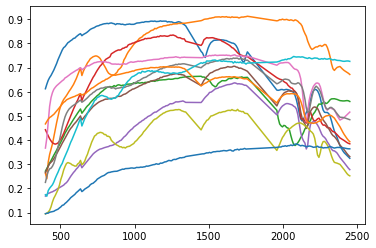

In [42]:
dataset = "cuprite"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

plot(wavelength, spectra[0])
plot(wavelength, spectra[1])
plot(wavelength, spectra[2])
plot(wavelength, spectra[3])
plot(wavelength, spectra[4])
plot(wavelength, spectra[5])
plot(wavelength, spectra[6])
plot(wavelength, spectra[7])
plot(wavelength, spectra[8])
plot(wavelength, spectra[9])
plot(wavelength, spectra[10])
plot(wavelength, spectra[11])
plt.show()

N,M,P = a_map.shape
_,_,K = hypercube.shape

In [43]:
hypercube = hypercube/sqrt(mean(hypercube**2))



In [ ]:
hypercube += rand(N,M,K)*0.1

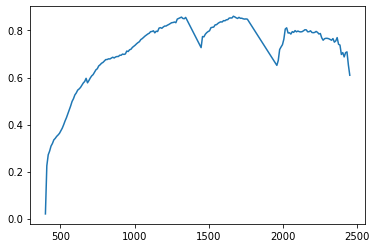

In [44]:


plot(wavelength, hypercube[20,20,:])

In [45]:
predicted_NNLS = abundance_maps.amaps.NNLS(hypercube.reshape((N*M,K)), spectra) # (N*M x P)
accuracy_NNLS = sqrt(mean((a_map.reshape((N*M,len(spectra)))-predicted_NNLS)**2))
accuracy_NNLS

0.28971902139398603

# Denoising using cv2 (operate on a_map, post_processing)

In [46]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def denoising_cv (hypercube,abundance_map, endmembers):
    N,M,P = abundance_map.shape
    _,_,K = hypercube.shape
    images = zeros((N,M,P))
    
    for i in range(P):
        predicted_NNLS = abundance_maps.amaps.NNLS(hypercube.reshape((N*M,K)), spectra) # (N*M x P)
        images[:,:,i] = (255*(predicted_NNLS[:,i]/max(predicted_NNLS[:,i]))).reshape(N,M)
        image_gray = images[:,:,i].reshape(N,M)
        image_gray = np.uint8(image_gray)
        images_clean = cv2.fastNlMeansDenoising(image_gray)
        images[:,:,i] = images_clean/255
    
    return images

In [47]:
images = denoising_cv (hypercube,a_map, spectra)

In [48]:
accuracy_denoising = sqrt(mean((a_map.reshape((N*M,len(spectra)))-images.reshape((N*M,len(spectra))))**2))
accuracy_denoising

0.18283655325362286

Text(0.5, 1.0, 'Cuprite CV2 noise reduction')

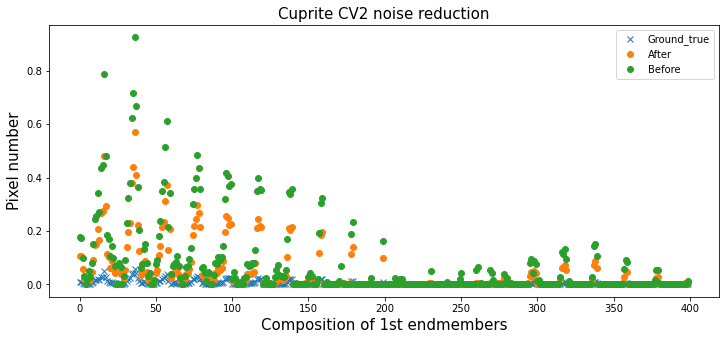

In [77]:
plt.rcParams['figure.figsize'] = [12, 5]

f1= a_map[120:140,120:140,0].reshape(20*20)
f2 = images[120:140,120:140,0].reshape(20*20)
f3 = predicted_NNLS.reshape(N,M,P)
f3 = f3[120:140,120:140,0].reshape(20*20)

f1 = f1.tolist()
f2 = f2.tolist()
f3 = f3.tolist()

plot(f1,'x',label = 'Ground_true')
plot(f2,'o',label = 'After')
plot(f3,'o',label = 'Before')
legend(loc=1)

xlabel("Composition of 1st endmembers",fontsize=15)
ylabel("Pixel number",fontsize=15)

title('Cuprite CV2 noise reduction',fontsize=15)


AttributeError: 'AxesSubplot' object has no attribute 'plt'

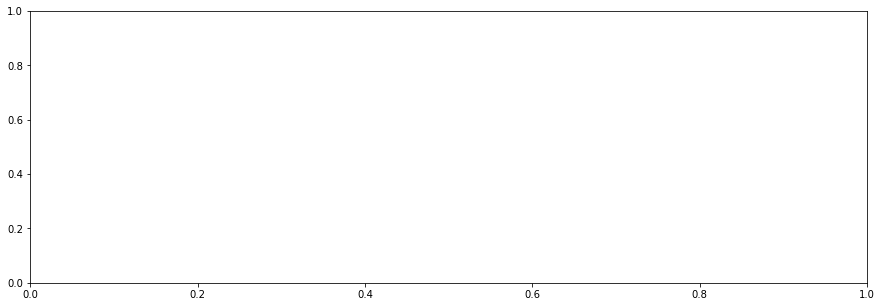

# Hypercube Noise Reduction (pre_processing)

In [11]:
from scipy.signal import lfilter

def hypercube_noise_reduction(hypercube,smoother_factor_n = 15.,smoother_factor_a = 1.):
    N,M,K = hypercube.shape
    P,_ = endmembers.shape
    
    
    hyper_s = hypercube.reshape(N*M,K)
    n = smoother_factor_n 
    b = [1.0 / n] * n
    a = smoother_factor_a
    
    for i in range (N*M):
        y = hyper_s[i,:]
        yy = lfilter(b,a,y)
        hyper_s[i,:] = yy

    
    hyper_s = hyper_s.reshape((N,M,K))
    
    
    return hyper_s

In [12]:
hyper_SS = hypercube_noise_reduction(hypercube,smoother_factor_n = 5, smoother_factor_a = 1)

In [13]:
hyper_SS.shape

(250, 190, 188)

In [14]:
spectra.shape

(12, 188)

In [15]:
predicted_NNLS_nd = abundance_maps.amaps.NNLS(hyper_SS.reshape((N*M,K)), spectra) 
accuracy_NNLS_nd = sqrt(mean((a_map.reshape((N*M,len(spectra)))-predicted_NNLS_nd)**2))
accuracy_NNLS_nd

0.3130875241561698

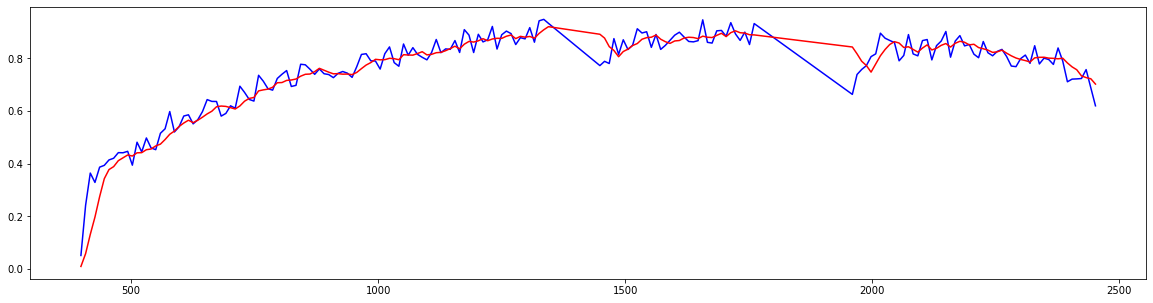

In [16]:
plt.plot(wavelength,hypercube[20,20,:],'b')
plt.plot(wavelength,hyper_SS[20,20,:],'r')

Text(0.5, 1.0, 'Cuprite pixel at (20,20)')

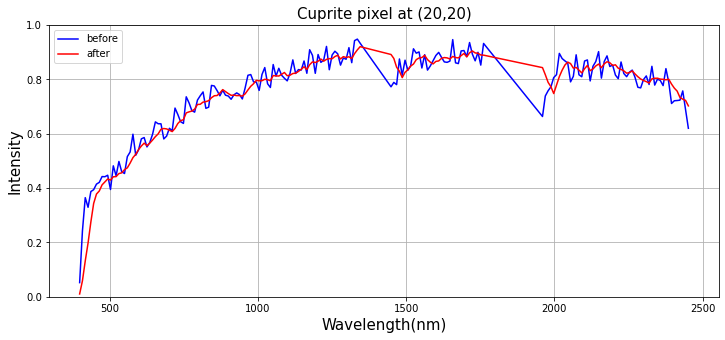

In [32]:
plt.rcParams['figure.figsize'] = [12, 5]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wavelength, hypercube[20,20,:],'-b', label = 'before')

ax.grid()
ax.plot(wavelength, hyper_SS[20,20,:],'-r', label = 'after')
ax.legend(loc=2)
ax.set_xlabel("Wavelength(nm)",fontsize=15)
ax.set_ylabel("Intensity",fontsize=15)
ax.set_ylim(0,1)

title('Cuprite pixel at (20,20)',fontsize=15)